## Import the image_embeddings lib

In [ ]:
!pip install image_embeddings # don't run this line if running this directly in the repo

In [1]:
import image_embeddings

## Download an example dataset

For this notebook, I download a dataset from https://www.tensorflow.org/datasets/catalog/overview
but any image can be used.
For example :
* tf_flowers
* stanford_dogs
* mnist
* fashion_mnist
* horses_or_humans

In [2]:
# Let's define some paths where to save images, tfrecords and embeddings
from pathlib import Path
home = str(Path.home())
dataset = "tf_flowers"
path_images = f"{home}/{dataset}/images"
path_tfrecords = f"{home}/{dataset}/tfrecords"
path_embeddings = f"{home}/{dataset}/embeddings"

In [3]:
image_embeddings.downloader.save_examples_to_folder(output_folder=path_images, images_count=1000, dataset=dataset)

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: tf_flowers/3.0.1
INFO:absl:Load dataset info from /tmp/tmpzi_nv2hetfds
INFO:absl:Generating dataset tf_flowers (/home/rom1504/tensorflow_datasets/tf_flowers/3.0.1)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



INFO:absl:Load dataset info from /home/rom1504/tensorflow_datasets/tf_flowers/3.0.1.incompleteJG0WW4
INFO:absl:Constructing tf.data.Dataset for split train, from /home/rom1504/tensorflow_datasets/tf_flowers/3.0.1




Dataset tf_flowers downloaded and prepared to /home/rom1504/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


## Transform image to tf records

Tf record is an efficient format to store image, it's better to use than raw image file for inference

In [4]:
image_embeddings.inference.write_tfrecord(image_folder=path_images,
                                          output_folder=path_tfrecords,
                                          num_shards=10)

Shard 0 saved after 0s
Shard 1 saved after 0s
Shard 2 saved after 0s
Shard 3 saved after 0s
Shard 4 saved after 0s
Shard 5 saved after 1s
Shard 6 saved after 1s
Shard 7 saved after 1s
Shard 8 saved after 1s
Shard 9 saved after 1s


## Build embeddings

Here, efficientnet is used, but the code is particularly simple, and any other model could be used
The input is tfrecords and the output is embeddings

In [5]:
image_embeddings.inference.run_inference(tfrecords_folder=path_tfrecords,
                                         output_folder=path_embeddings,
                                         batch_size=1000)

1/1 [==============================] - 0s 14ms/step

Shard 0 done after 6s
Shard 0 saved after 6s
1/1 [==============================] - 0s 7ms/step

Shard 1 done after 11s
Shard 1 saved after 11s
1/1 [==============================] - 0s 5ms/step

Shard 2 done after 16s
Shard 2 saved after 16s
1/1 [==============================] - 0s 5ms/step

Shard 3 done after 21s
Shard 3 saved after 21s
1/1 [==============================] - 0s 9ms/step

Shard 4 done after 26s
Shard 4 saved after 26s
1/1 [==============================] - 0s 5ms/step

Shard 5 done after 31s
Shard 5 saved after 31s
1/1 [==============================] - 0s 6ms/step

Shard 6 done after 36s
Shard 6 saved after 36s
1/1 [==============================] - 0s 7ms/step

Shard 7 done after 41s
Shard 7 saved after 41s
1/1 [==============================] - 0s 7ms/step

Shard 8 done after 45s
Shard 8 saved after 46s
1/1 [==============================] - 0s 5ms/step

Shard 9 done after 50s
Shard 9 saved after 50s


## Read the embeddings and build an index with it

The knn index is built using https://github.com/facebookresearch/faiss which makes it possible
to search embeddings in log(N) with lot of options to reduce memory footprint

In [31]:
[id_to_name, name_to_id, embeddings] = image_embeddings.knn.read_embeddings(path_embeddings)
index = image_embeddings.knn.build_index(embeddings)

## Search in the index

Let's pick a random product by id, retrieve its embedding and search in the index

Then let's display the closest products

image_dandelion_443


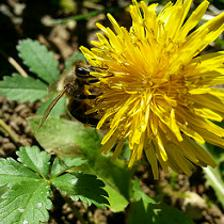

In [21]:
p=225
print(id_to_name[p])
image_embeddings.knn.display_picture(path_images, id_to_name[p])
results = image_embeddings.knn.search(index, id_to_name, embeddings[p])
image_embeddings.knn.display_results(path_images, results)

## Combination of images ?

Any vector in the same space can be used as query
For example I could have 2 image and want to find some example that are closeby to the 2, 
Let's just average them and see that happens !

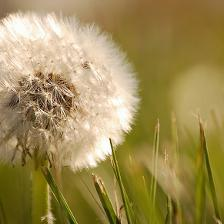

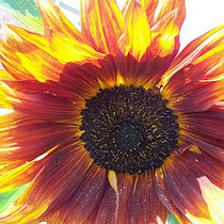

In [32]:
p1 = 19
p2 = 67
image1 = id_to_name[p1]
image2 = id_to_name[p2]
image_embeddings.knn.display_picture(path_images, image1)
image_embeddings.knn.display_picture(path_images, image2)
results = image_embeddings.knn.search(index, id_to_name, (embeddings[p1] + embeddings[p2])/2, 7)
image_embeddings.knn.display_results(path_images, results)

We get mostly one of the picture. One thing that can be done to improve this is to
normalize the embeddings to get a better mix, let's try it !

In [33]:
import numpy as np

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)
normalized_embeddings = normalized(embeddings, 1)
index_normalized = image_embeddings.knn.build_index(normalized_embeddings)

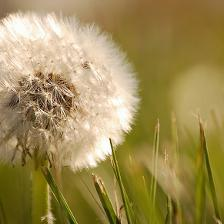

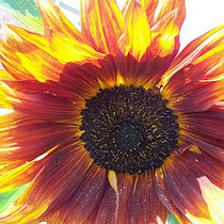

In [34]:
p1 = 19
p2 = 67
image1 = id_to_name[p1]
image2 = id_to_name[p2]
image_embeddings.knn.display_picture(path_images, image1)
image_embeddings.knn.display_picture(path_images, image2)
results = image_embeddings.knn.search(index_normalized, id_to_name, (normalized_embeddings[p1] + normalized_embeddings[p2])/2, 7)
image_embeddings.knn.display_results(path_images, results)

As expected we see a mixture of images that looks like both

## Next ?

What else can you build with this ?

An obvious example is retrieval (looking for closeby pictures) but recommendation systems or photo managers can also work very well using image embeddings !